In [0]:
#Importing necessary Libraries
from google.colab import drive
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import ImageFilter
import PIL.ImageOps  
import cv2
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split # for splitting training and testing


In [0]:
#Mounting Google Drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
os.chdir('/content/drive/My Drive/Dataset Tom and Jerry/')

### ***Creation of Training Dataset***

In [0]:
#Converting video into images by extracting frames from the training video.
i=0
count=0
cap = cv2.VideoCapture('Train Tom and Jerry.mp4')
frame_rate = cap.get(cv2.CAP_PROP_FPS)
while True:
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    count += math.floor(frame_rate)
    print(count)
    ret, frame = cap.read()
    
    
    if ret != True :
        break
        
    cv2.imwrite("Train images/"+"frame"+str(i)+".jpg",frame)
    i+=1
    
cap.release()
    


In [0]:
#Data Augmentation to increase the size of dataset using two techniques namely mirroring and Saturation using PIL Library. 
#Note that the augmented images have been saved manually in the same directory as the original training images.
for i in range(len(b)):
  image = Image.open(b[i])
  image_flip = image.transpose(Image.FLIP_LEFT_RIGHT)
  image_flip.save('flipped-'+b[i])



for i in range(len(b)):
    img = Image.open(b[i])
    enhancer = ImageEnhance.Color(img)
    img_saturation = enhancer.enhance(2)
    img_saturation.save('saturation-'+b[i])
 

In [0]:
os.chdir('/content/drive/My Drive/Dataset Tom and Jerry/Train images')

In [0]:
b=os.listdir()
len(b)

1192

In [0]:
#Resizing images to a shape of (224,224,3) and converting images into a numpy array. 
data=[]
for i in range(len(b)):
  image_arr = cv2.imread(b[i])
  #data.append(image_arr)
  data.append(cv2.resize(image_arr, (224,224), interpolation = cv2.INTER_CUBIC))

In [0]:
rgb_img = np.array((data))
rgb_img.shape

(1192, 224, 224, 3)

In [0]:
os.chdir('/content/drive/My Drive/Dataset Tom and Jerry/')

In [0]:
#Reading the csv file to extract labels corresponding to each frame that we have extracted from the training video.
csv = pd.read_csv('Train.csv')
csv.shape[0]

298

In [0]:
#Labelling the frames to the corresponding labels
label=[]
for i in range(len(b)):
  for j in range(csv.shape[0]):
    if csv.iloc[j,0] in b[i]:
      label.append(csv.iloc[j,1])


In [0]:
classes=np.array((label))
classes=classes.reshape(len(b),1)
classes.shape

(1192, 1)

In [0]:
# integer encoding of the labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)
# One Hot Encoding of the labels
onehot_encoder = OneHotEncoder(sparse=False)

In [0]:
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)
y.shape

(1192, 5)

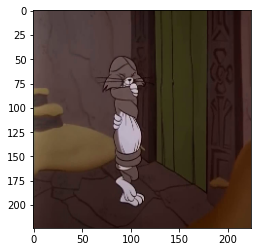

In [0]:
plt.imshow(rgb_img[0])

In [0]:
#Splitting the data into training and validation sets
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(rgb_img,y,random_state=1,test_size=0.25)
x_train.shape,x_valid.shape,y_train.shape,y_valid.shape

((894, 224, 224, 3), (298, 224, 224, 3), (894, 5), (298, 5))

In [0]:
#Normalizing the pixel values
x_train= x_train/255
x_valid = x_valid/255

In [0]:
#Conversion into float32 datatype values
x_train=np.array(x_train,dtype='float32')
x_valid=np.array(x_valid,dtype='float32')
y_train.astype(dtype='float32')
y_valid.astype(dtype='float32')

# ***BUILDING THE MODEL FOR CLASSIFICATION OF IMAGES INTO 5 CLASSES OF EMOTIONS.***




In [0]:
#Importing necessary libraries
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,LeakyReLU, ReLU, InputLayer
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras import optimizers
%matplotlib inline

In [0]:
#CNN MODEL

model = Sequential()

# First Layer
model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same',activation='relu',input_shape=(224,224,3)))

model.add(Conv2D(filters=32,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Dropout(0.25))

model.add(Flatten()) #Flattens the matrix into a vector
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax')) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0

In [0]:
#Optimising the cost
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer= 'Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) #Compiling the model

In [0]:

from keras.callbacks import ModelCheckpoint  #Checkpoint to save the best weights of the model.

#checkpointer = ModelCheckpoint(filepath="model_1.h5",   
#                               monitor = "val_acc", 
#                               mode = "max",
#                               verbose=1, 
#                               save_best_only=True) 

earlystop = EarlyStopping(monitor = 'val_acc', # value being monitored for improvement
                          mode = "max",
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 5, #Number of epochs we wait before stopping 
                          verbose = 1) #keeps the best weigths once stopped

history = model.fit(x_train, y_train, 
          validation_data=(x_valid,y_valid), 
          epochs=20, batch_size=32, callbacks=[earlystop], verbose=1,shuffle=True)

Epoch 1/20
28/28 [==============================] - 1s 40ms/step - loss: 0.2726 - accuracy: 0.9195 - val_loss: 0.4891 - val_accuracy: 0.8289
Epoch 2/20
28/28 [==============================] - 1s 40ms/step - loss: 0.2123 - accuracy: 0.9251 - val_loss: 0.5188 - val_accuracy: 0.8490
Epoch 3/20
28/28 [==============================] - 1s 39ms/step - loss: 0.2018 - accuracy: 0.9329 - val_loss: 0.5007 - val_accuracy: 0.8557
Epoch 4/20
28/28 [==============================] - 1s 39ms/step - loss: 0.1775 - accuracy: 0.9295 - val_loss: 0.5124 - val_accuracy: 0.8523
Epoch 5/20
28/28 [==============================] - 1s 39ms/step - loss: 0.1816 - accuracy: 0.9351 - val_loss: 0.5136 - val_accuracy: 0.8490
Epoch 6/20
28/28 [==============================] - 1s 39ms/step - loss: 0.2047 - accuracy: 0.9351 - val_loss: 0.5220 - val_accuracy: 0.8490
Epoch 7/20
28/28 [==============================] - 1s 40ms/step - loss: 0.1912 - accuracy: 0.9430 - val_loss: 0.5220 - val_accuracy: 0.8691
Epoch 8/20
28

# **Transfer Learning / Using Pre-Trained Models **

In [0]:
#Downloading the weights of VGG-16 Model
from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
#Keeping the pre-trained weights frozen and adding 2 more hidden layers on the top
model4 = Sequential()
model4.add(vgg16)
model4.add(layers.Flatten())

model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dropout(0.25))
model4.add(layers.Dense(5, activation='softmax'))

model4.layers[0].trainable = False


model4.summary()


model4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 21,138,757
Trainable params: 6,424,069
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
es1 = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=10
)

history4 = model4.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=50,batch_size = 32,callbacks=[es1], verbose=1,shuffle=True)

Epoch 1/50
28/28 [==============================] - 4s 143ms/step - loss: 3.2377 - accuracy: 0.4776 - val_loss: 0.9385 - val_accuracy: 0.6242
Epoch 2/50
28/28 [==============================] - 3s 105ms/step - loss: 0.6254 - accuracy: 0.7830 - val_loss: 0.6049 - val_accuracy: 0.8020
Epoch 3/50
28/28 [==============================] - 3s 105ms/step - loss: 0.3540 - accuracy: 0.8971 - val_loss: 0.4448 - val_accuracy: 0.8624
Epoch 4/50
28/28 [==============================] - 3s 105ms/step - loss: 0.2529 - accuracy: 0.9239 - val_loss: 0.3431 - val_accuracy: 0.8893
Epoch 5/50
28/28 [==============================] - 3s 105ms/step - loss: 0.1882 - accuracy: 0.9351 - val_loss: 0.3344 - val_accuracy: 0.8859
Epoch 6/50
28/28 [==============================] - 3s 105ms/step - loss: 0.1682 - accuracy: 0.9530 - val_loss: 0.3156 - val_accuracy: 0.9027
Epoch 7/50
28/28 [==============================] - 3s 105ms/step - loss: 0.1429 - accuracy: 0.9586 - val_loss: 0.2889 - val_accuracy: 0.9195
Epoch 

**Creation of Testing Dataset**

In [0]:
#Converting video into images by extracting frames from the testing video.
i=0
count=0
cap = cv2.VideoCapture('Test Tom and Jerry.mp4')
frame_rate = cap.get(cv2.CAP_PROP_FPS)
while True:
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    count += math.floor(frame_rate)
    print(count)
    ret, frame = cap.read()
    
    
    if ret != True :
        break
        
    cv2.imwrite("Test images/"+"frame"+str(i)+".jpg",frame)
    i+=1
    
cap.release()
    


In [0]:
os.chdir('/content/drive/My Drive/Dataset Tom and Jerry/Test images')

In [0]:
c=os.listdir()
len(c)

186

In [0]:
#Resizing images to a shape of (224,224,3) and converting images into a numpy array. Also the frame number is stored inside the test_frames list.
test_data=[]
test_frames=[]
for i in range(len(c)):
    image_arr = cv2.imread(c[i])
    test_data.append(cv2.resize(image_arr, (224,224), interpolation = cv2.INTER_CUBIC))
    test_frames.append(c[i])

In [0]:
x_test = np.array((test_data))
x_frames =np.array((test_frames))
x_frames = x_frames.reshape(186,1)
x_test.shape,x_frames.shape

((186, 224, 224, 3), (186, 1))

## ***Predictions made using Self Proposed CNN Architecture***

In [0]:
predictions = model.predict(x_test)
p = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in x_test]


In [0]:
#Decoding prediction labels
final_p = []
for i in range(len(p)):
    if p[i]==0:
        final_p.append('Unknown')
    elif p[i]==1:
        final_p.append('angry')
    elif p[i]==2:
        final_p.append('happy')
    elif p[i]==3:
        final_p.append('sad')
    elif p[i]==4:
        final_p.append('surprised')
        

In [0]:
result = np.array((final_p))
result = result.reshape(186,1)
result.shape

(186, 1)

In [0]:
#Putting frames with corresponding predictions to convert it into a csv file
z = [x_frames,result]
z = np.array((z))
final = z.T
final=final.reshape(186,2)

In [0]:
#Saving the results into a csv file
np.savetxt('../Self_proposed_CNN_test.csv',final,delimiter=',',fmt='%s')

## **Predictions made using Pre-Trained VGG-16 Model**

In [0]:
predictions = model4.predict(x_test)
p_vgg16 = [np.argmax(model4.predict(np.expand_dims(feature, axis=0))) for feature in x_test]


In [0]:
#Decoding prediction labels
final_p = []
for i in range(len(p)):
    if p_vgg16[i]==0:
        final_p.append('Unknown')
    elif p_vgg16[i]==1:
        final_p.append('angry')
    elif p_vgg16[i]==2:
        final_p.append('happy')
    elif p_vgg16[i]==3:
        final_p.append('sad')
    elif p_vgg16[i]==4:
        final_p.append('surprised')
        

In [0]:
result_vgg16 = np.array((final_p))
result_vgg16 = result_vgg16.reshape(186,1)

In [0]:
#Putting frames with corresponding predictions to convert it into a csv file
z = [x_frames,result_vgg16]
z = np.array((z))
final_vgg16 = z.T
final_vgg16=final_vgg16.reshape(186,2)

In [0]:
#Saving the results into a csv file
np.savetxt('../VGG_16_test.csv',final,delimiter=',',fmt='%s')